# Importing needed libraries

In [281]:
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
import matplotlib.style as style
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier  
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score 
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import seaborn as sns

import matplotlib.pyplot as plt

# Loading our data

In [282]:
df = pd.read_csv('/kaggle/input/spaceship-titanic/train.csv')

### spliting training data to get the accuray of the model

In [283]:
train_df = df[:7000]
test_df = df[7000:]

In [284]:
submission = pd.read_csv('../input/spaceship-titanic/sample_submission.csv')
submission.head()

,PassengerId,Transported
0,0013_01,False
1,0018_01,False
2,0019_01,False
3,0021_01,False
4,0023_01,False


# EDA

### We try to explore the dataset to get more famalliar with it

In [285]:
# get the columns of the training dataset
train_df.columns

Index(['PassengerId', 'HomePlanet', 'CryoSleep', 'Cabin', 'Destination', 'Age',
       'VIP', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck',
       'Name', 'Transported'],
      dtype='object')

### drop useless columns

In [286]:
cols_to_drop = ['PassengerId', 'Cabin', 'Name']

train_df = train_df.drop(cols_to_drop, axis=1)
test_df = test_df.drop(cols_to_drop, axis=1)

In [287]:
train_df.shape


(7000, 11)

In [288]:
test_df.shape


(1693, 11)

In [289]:
train_df.head()

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported
0,Europa,False,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,False
1,Earth,False,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,True
2,Europa,False,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,False
3,Europa,False,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,False
4,Earth,False,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,True


In [290]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7000 entries, 0 to 6999
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   HomePlanet    6839 non-null   object 
 1   CryoSleep     6825 non-null   object 
 2   Destination   6848 non-null   object 
 3   Age           6846 non-null   float64
 4   VIP           6840 non-null   object 
 5   RoomService   6849 non-null   float64
 6   FoodCourt     6846 non-null   float64
 7   ShoppingMall  6830 non-null   float64
 8   Spa           6852 non-null   float64
 9   VRDeck        6837 non-null   float64
 10  Transported   7000 non-null   bool   
dtypes: bool(1), float64(6), object(4)
memory usage: 553.8+ KB


### As we can se our data has some null values in some of ots columns

In [291]:
train_df.nunique()

HomePlanet         3
CryoSleep          2
Destination        3
Age               80
VIP                2
RoomService     1133
FoodCourt       1299
ShoppingMall    1001
Spa             1144
VRDeck          1135
Transported        2
dtype: int64

In [292]:
# to find how many null value each column has
train_df.isna().sum()

HomePlanet      161
CryoSleep       175
Destination     152
Age             154
VIP             160
RoomService     151
FoodCourt       154
ShoppingMall    170
Spa             148
VRDeck          163
Transported       0
dtype: int64

<Axes: >

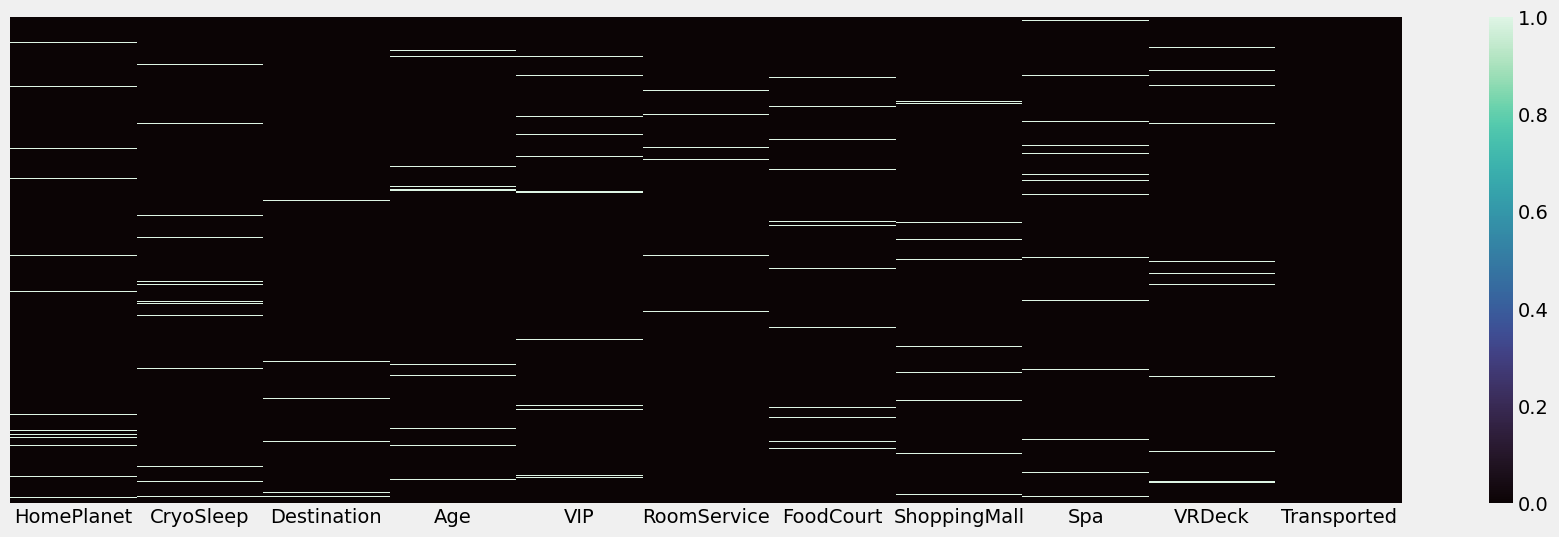

In [293]:
plt.figure(figsize=(20,6))
sns.heatmap(train_df.isnull(),yticklabels=False,cbar=True,cmap='mako')

# Finding numerical features

In [294]:
num_col=train_df._get_numeric_data().columns.tolist()
num_col

['Age',
 'RoomService',
 'FoodCourt',
 'ShoppingMall',
 'Spa',
 'VRDeck',
 'Transported']

In [295]:
display(train_df.describe().transpose())

,count,mean,std,min,25%,50%,75%,max
Age,6846.0,28.905200,14.558361,0.0,19.0,27.0,38.00,79.0
RoomService,6849.0,224.530734,660.372149,0.0,0.0,0.0,48.00,14327.0
FoodCourt,6846.0,459.901694,1636.099892,0.0,0.0,0.0,76.00,29813.0
ShoppingMall,6830.0,174.482430,551.034770,0.0,0.0,0.0,27.75,12253.0
Spa,6852.0,312.931115,1151.952828,0.0,0.0,0.0,57.00,22408.0
VRDeck,6837.0,301.357028,1136.879256,0.0,0.0,0.0,44.00,24133.0


# Finding categorical features

In [296]:
cat_col= ['CryoSleep', 'Destination', 'HomePlanet', 'VIP']

In [297]:
for i in cat_col:
    print(train_df[i].value_counts())

CryoSleep
False    4391
True     2434
Name: count, dtype: int64
Destination
TRAPPIST-1e      4776
55 Cancri e      1452
PSO J318.5-22     620
Name: count, dtype: int64
HomePlanet
Earth     3692
Europa    1715
Mars      1432
Name: count, dtype: int64
VIP
False    6692
True      148
Name: count, dtype: int64


# Handling missing values

### we use specific techniques to fill all null values

In [298]:
# mean strategy for numerical columns ( we could use some advanced techniques like regression or ...)
numeric_imputer = SimpleImputer(strategy='mean')
# most_frequent strategy for categorical columns
categorical_imputer = SimpleImputer(strategy='most_frequent')

train_df[num_col] = numeric_imputer.fit_transform(train_df[num_col])
train_df[cat_col] = categorical_imputer.fit_transform(train_df[cat_col])

### Now we check to see if any null value exist anymore in our dataset

In [299]:
train_df.isna().sum()

HomePlanet      0
CryoSleep       0
Destination     0
Age             0
VIP             0
RoomService     0
FoodCourt       0
ShoppingMall    0
Spa             0
VRDeck          0
Transported     0
dtype: int64

In [300]:
# spliting dataset to continue our preprocessing parts seperatlly
test_df[num_col] = numeric_imputer.fit_transform(test_df[num_col])
test_df[cat_col] = categorical_imputer.fit_transform(test_df[cat_col])

## Ploting some features to see their ditribution

In [301]:
def plot_num_feature_dist(train_df,feature):
        sns.histplot(data=train_df, x=feature, kde=True)
        plt.xlabel(feature)
        plt.ylabel('Count')
        plt.title(f" {feature}'s distribution ")
        plt.show()

In [302]:
def plot_cat_feature_dist(train_df,feature,rotation=45):
        sns.countplot(data=train_df, x=feature)
        plt.xticks(rotation=rotation) 
        plt.xlabel(feature)
        plt.ylabel('Count')
        plt.title(f" {feature}'s distribution ")
        plt.show()

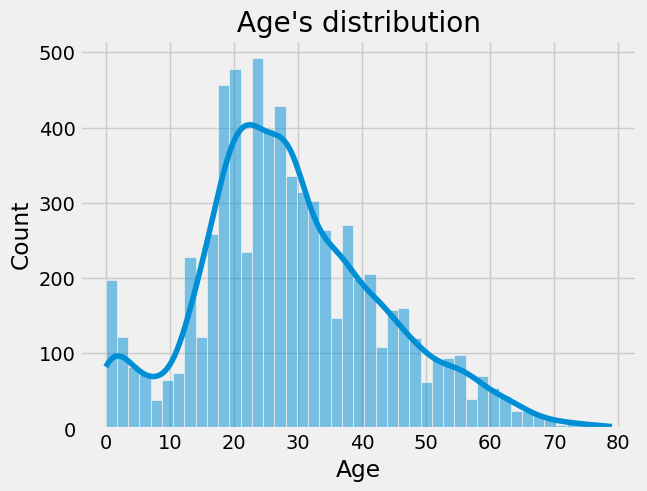

In [303]:
plot_num_feature_dist(train_df, 'Age')

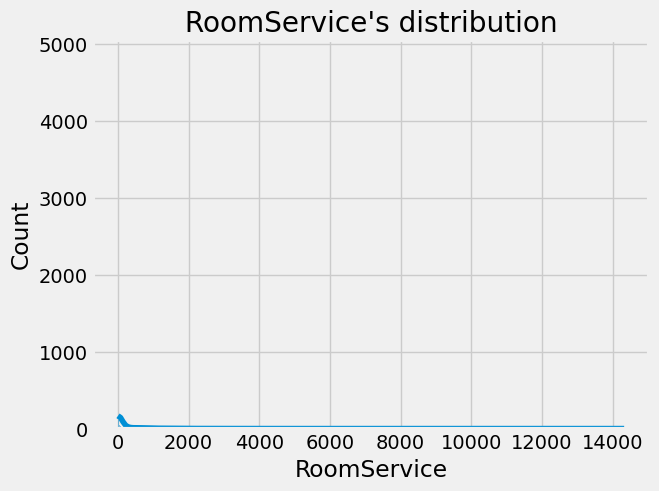

In [304]:
plot_num_feature_dist(train_df, 'RoomService')

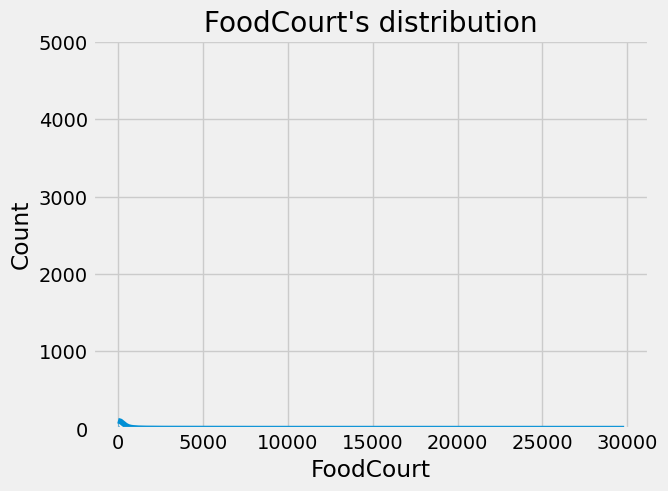

In [305]:
plot_num_feature_dist(train_df, 'FoodCourt')

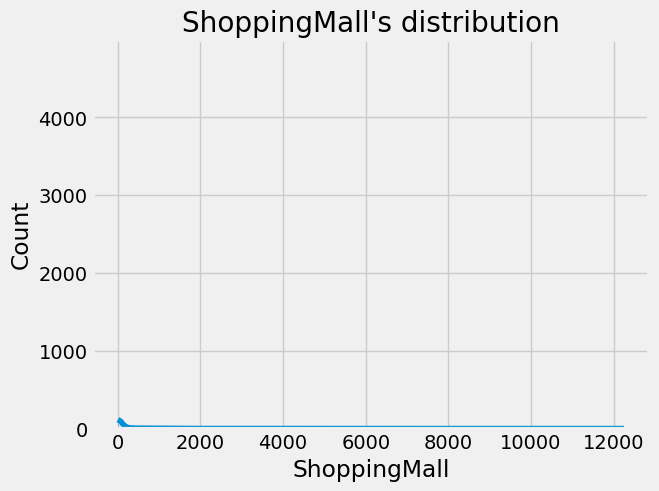

In [306]:
plot_num_feature_dist(train_df, 'ShoppingMall')

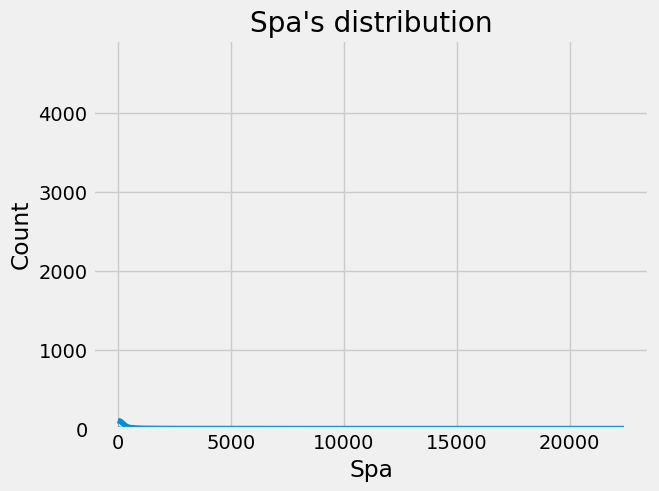

In [307]:
plot_num_feature_dist(train_df, 'Spa')

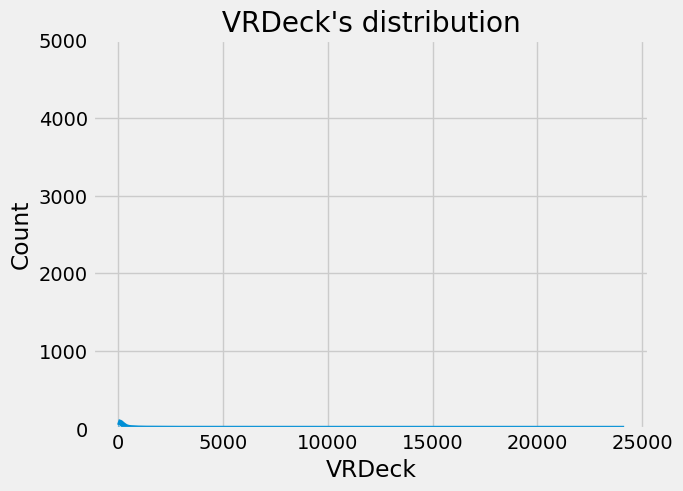

In [308]:
plot_num_feature_dist(train_df, 'VRDeck')

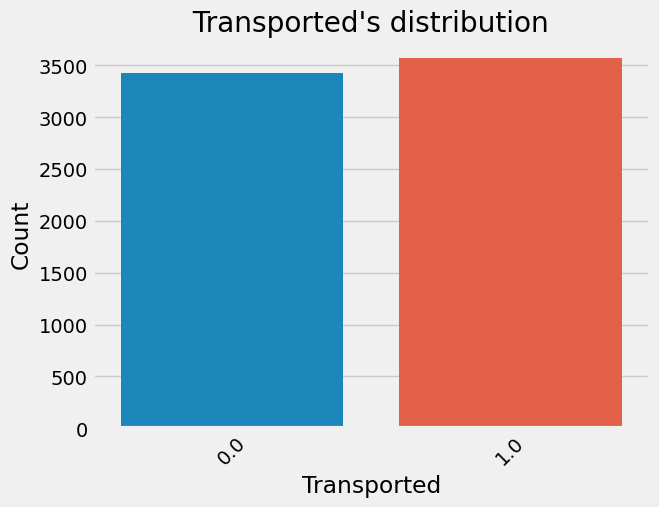

In [309]:
plot_cat_feature_dist(train_df, 'Transported')

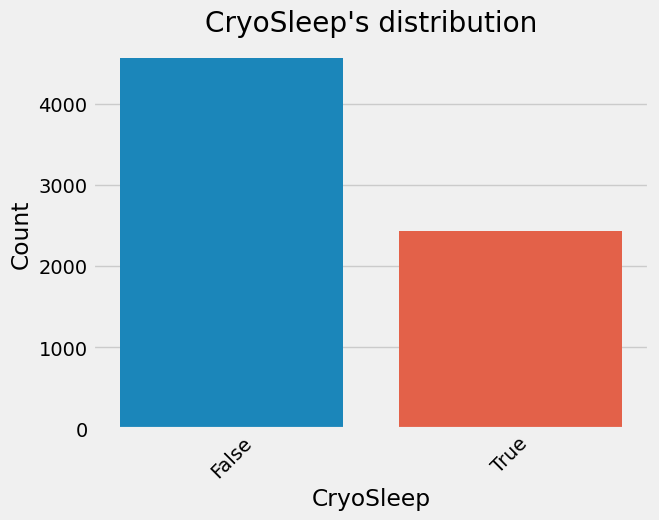

In [310]:
plot_cat_feature_dist(train_df, 'CryoSleep')


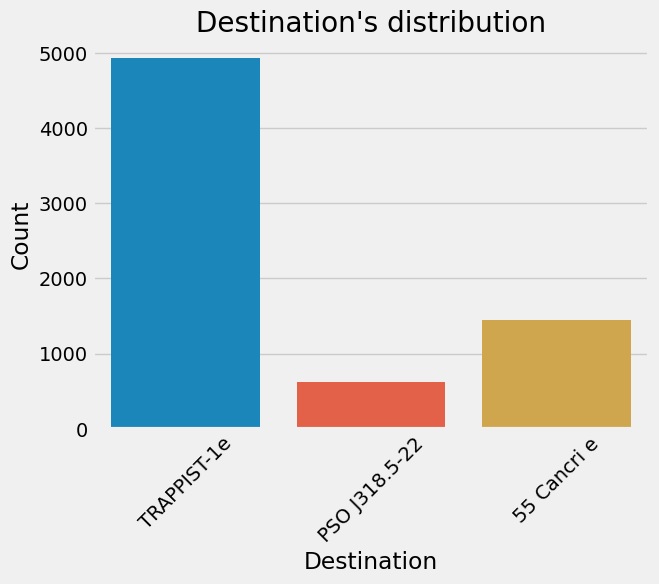

In [311]:
plot_cat_feature_dist(train_df, 'Destination')


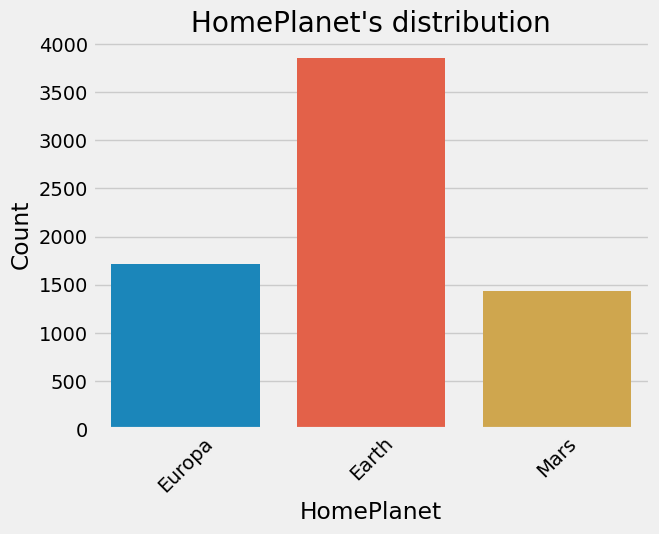

In [312]:
plot_cat_feature_dist(train_df, 'HomePlanet')


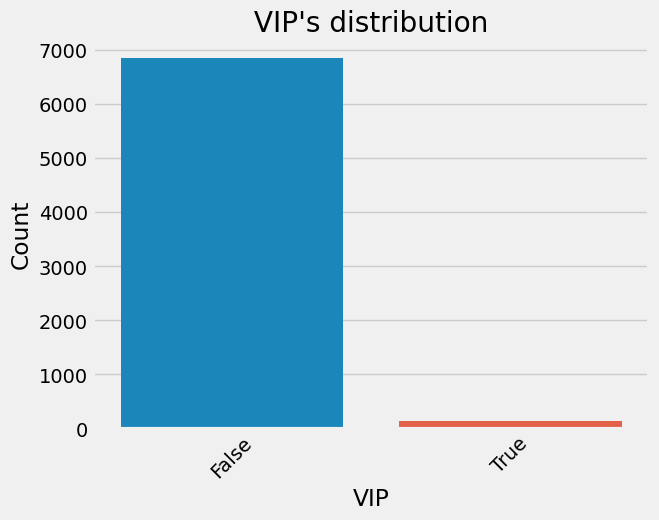

In [313]:
plot_cat_feature_dist(train_df, 'VIP')


# Encoding categirical features

In [314]:
num_col

['Age',
 'RoomService',
 'FoodCourt',
 'ShoppingMall',
 'Spa',
 'VRDeck',
 'Transported']

In [315]:
inp_num_col = ['Age',
 'RoomService',
 'FoodCourt',
 'ShoppingMall',
 'Spa',
 'VRDeck']
numeric_train_set = train_df[inp_num_col]
categorical_train_set = train_df[cat_col]

In [316]:
categorical_train_set = pd.get_dummies(categorical_train_set, 
                                      columns=categorical_train_set.select_dtypes(include=['object']).columns, dtype=int)
categorical_train_set = categorical_train_set.astype(int)

In [317]:
categorical_train_set.head()

,CryoSleep_False,CryoSleep_True,Destination_55 Cancri e,Destination_PSO J318.5-22,Destination_TRAPPIST-1e,HomePlanet_Earth,HomePlanet_Europa,HomePlanet_Mars,VIP_False,VIP_True
0,1,0,0,0,1,0,1,0,1,0
1,1,0,0,0,1,1,0,0,1,0
2,1,0,0,0,1,0,1,0,0,1
3,1,0,0,0,1,0,1,0,1,0
4,1,0,0,0,1,1,0,0,1,0


In [318]:
categorical_train_set.shape

(7000, 10)

In [319]:
numeric_test_set = test_df[inp_num_col]
categorical_test_set = test_df[cat_col]

In [320]:
categorical_test_set = pd.get_dummies(categorical_test_set, 
                                      columns=categorical_test_set.select_dtypes(include=['object']).columns, dtype=int)
categorical_test_set = categorical_test_set.astype(int)


In [321]:
categorical_test_set.head()

,CryoSleep_False,CryoSleep_True,Destination_55 Cancri e,Destination_PSO J318.5-22,Destination_TRAPPIST-1e,HomePlanet_Earth,HomePlanet_Europa,HomePlanet_Mars,VIP_False,VIP_True
7000,0,1,0,0,1,1,0,0,1,0
7001,1,0,0,0,1,1,0,0,1,0
7002,1,0,0,0,1,0,0,1,1,0
7003,1,0,1,0,0,1,0,0,1,0
7004,1,0,0,1,0,1,0,0,1,0


In [322]:
categorical_test_set.shape

(1693, 10)

# Normalazing train dataset

In [323]:
scaler = StandardScaler()

In [324]:
numeric_train_set.head()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
0,39.0,0.0,0.0,0.0,0.0,0.0
1,24.0,109.0,9.0,25.0,549.0,44.0
2,58.0,43.0,3576.0,0.0,6715.0,49.0
3,33.0,0.0,1283.0,371.0,3329.0,193.0
4,16.0,303.0,70.0,151.0,565.0,2.0


In [325]:
numeric_train_set.columns = numeric_train_set.columns.astype(str)

In [326]:
numeric_train_set = pd.DataFrame(scaler.fit_transform(numeric_train_set), columns=numeric_train_set.columns)


In [327]:
numeric_train_set.head()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
0,0.701209,-0.343759,-0.284261,-0.320585,-0.274591,-0.268235
1,-0.340727,-0.176879,-0.278698,-0.274651,0.207146,-0.229071
2,2.020995,-0.277926,1.926033,-0.320585,5.617689,-0.224620
3,0.284435,-0.343759,0.508750,0.361071,2.646541,-0.096447
4,-0.896426,0.120137,-0.240995,-0.043145,0.221185,-0.266455


# Concating train's subdata to make full dataset

In [328]:
train_data = pd.concat([numeric_train_set, categorical_train_set,train_df['Transported']], axis=1)

In [329]:
len(train_data)

7000

In [330]:
train_data.head()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,CryoSleep_False,CryoSleep_True,Destination_55 Cancri e,Destination_PSO J318.5-22,Destination_TRAPPIST-1e,HomePlanet_Earth,HomePlanet_Europa,HomePlanet_Mars,VIP_False,VIP_True,Transported
0,0.701209,-0.343759,-0.284261,-0.320585,-0.274591,-0.268235,1,0,0,0,1,0,1,0,1,0,0.0
1,-0.340727,-0.176879,-0.278698,-0.274651,0.207146,-0.229071,1,0,0,0,1,1,0,0,1,0,1.0
2,2.020995,-0.277926,1.926033,-0.320585,5.617689,-0.224620,1,0,0,0,1,0,1,0,0,1,0.0
3,0.284435,-0.343759,0.508750,0.361071,2.646541,-0.096447,1,0,0,0,1,0,1,0,1,0,0.0
4,-0.896426,0.120137,-0.240995,-0.043145,0.221185,-0.266455,1,0,0,0,1,1,0,0,1,0,1.0


# Correlation with target Value

In [331]:
def customized_scatterplot(y, x):
    style.use('fivethirtyeight')
    plt.subplots(figsize = (12, 8))
    sns.scatterplot(y = y, x = x)

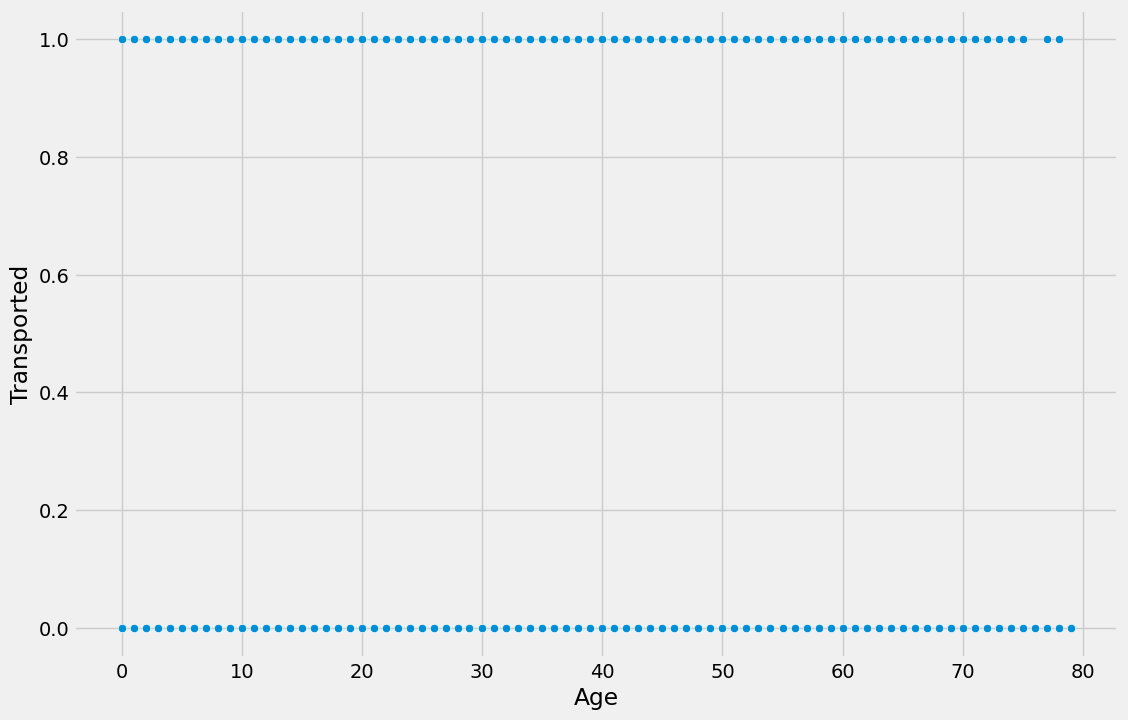

In [332]:
customized_scatterplot(train_df.Transported, train_df.Age)

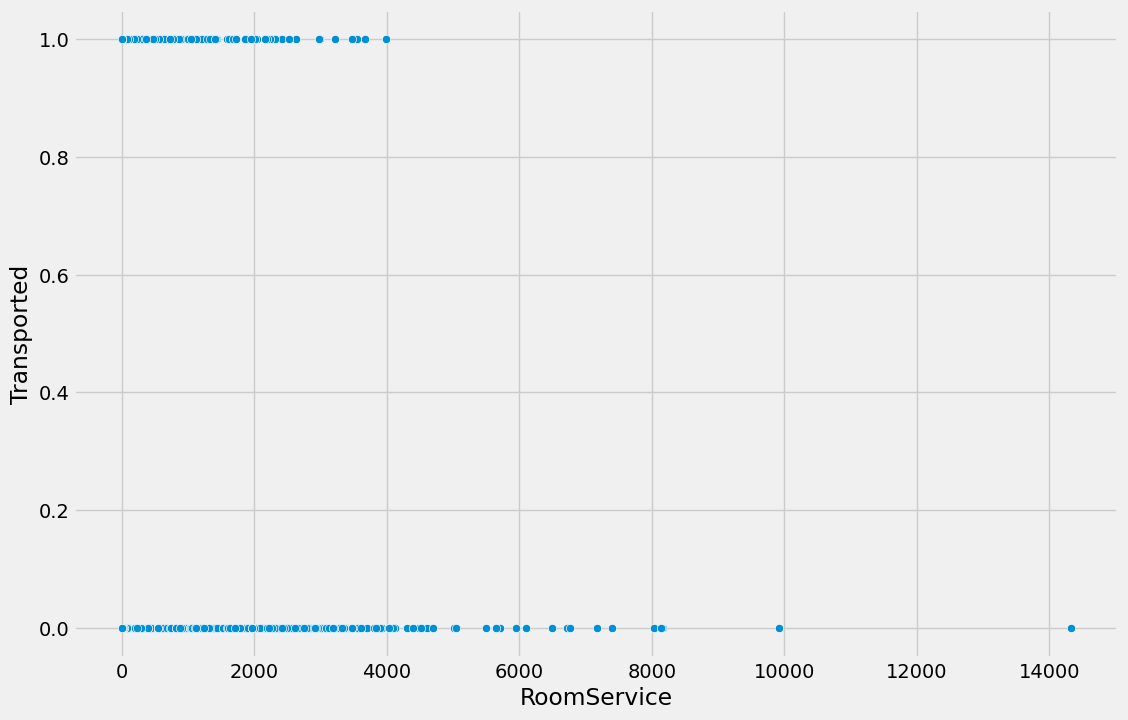

In [333]:
customized_scatterplot(train_df.Transported, train_df.RoomService)

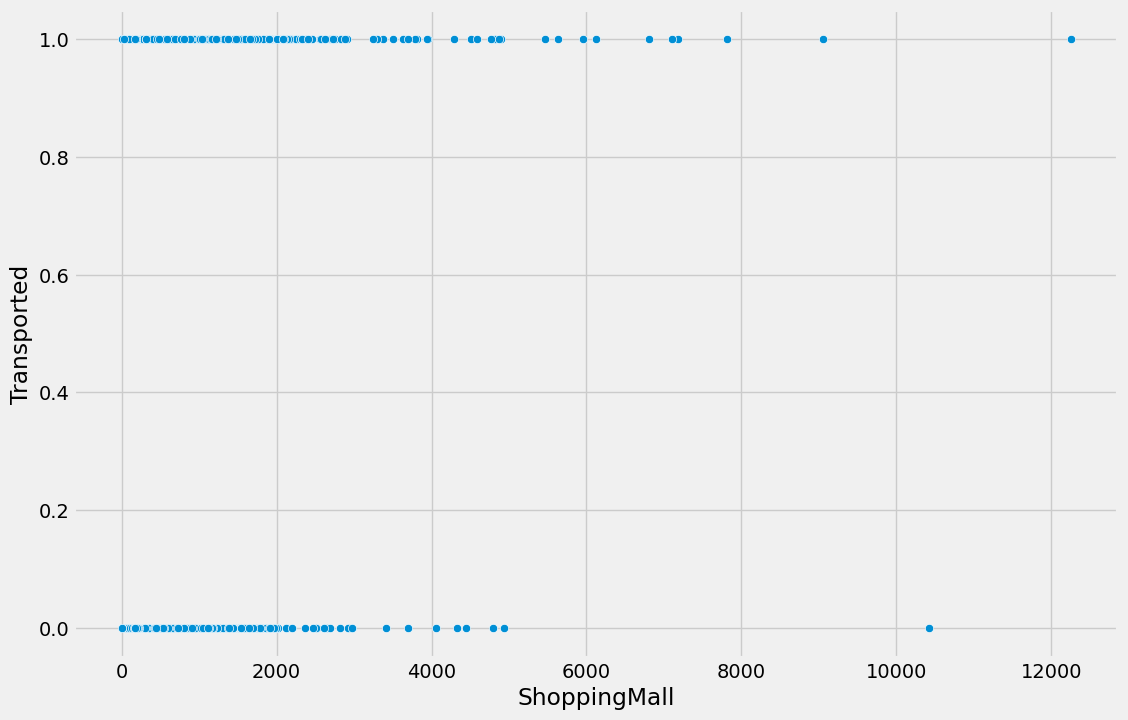

In [334]:
customized_scatterplot(train_df.Transported, train_df.ShoppingMall)

# Making input data

In [335]:
X_train = train_data.drop(columns=['Transported'])

In [336]:
len(X_train)

7000

In [337]:
y_train = train_data['Transported']

In [338]:
len(y_train)

7000

# Concating test's subdata to make full dataset

In [339]:
test_data = pd.concat([numeric_test_set, categorical_test_set,test_df['Transported']], axis=1)

In [340]:
len(test_data)

1693

In [341]:
test_data.head()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,CryoSleep_False,CryoSleep_True,Destination_55 Cancri e,Destination_PSO J318.5-22,Destination_TRAPPIST-1e,HomePlanet_Earth,HomePlanet_Europa,HomePlanet_Mars,VIP_False,VIP_True,Transported
7000,20.0,0.000000,0.0,0.0,0.0,0.0,0,1,0,0,1,1,0,0,1,0,0.0
7001,18.0,960.000000,672.0,0.0,0.0,168.0,1,0,0,0,1,1,0,0,1,0,0.0
7002,24.0,225.333734,0.0,299.0,814.0,0.0,1,0,0,0,1,0,0,1,1,0,0.0
7003,25.0,244.000000,0.0,40.0,294.0,124.0,1,0,1,0,0,1,0,0,1,0,0.0
7004,20.0,120.000000,321.0,0.0,932.0,175.0,1,0,0,1,0,1,0,0,1,0,0.0


In [342]:
X_test = test_data.drop(columns=['Transported'])

In [343]:
y_test = test_data['Transported']

In [344]:
len(X_test)

1693

In [345]:
len(y_test)

1693

# Machine Learning Model

### Random Forest Model

In [346]:
X_test.head()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,CryoSleep_False,CryoSleep_True,Destination_55 Cancri e,Destination_PSO J318.5-22,Destination_TRAPPIST-1e,HomePlanet_Earth,HomePlanet_Europa,HomePlanet_Mars,VIP_False,VIP_True
7000,20.0,0.000000,0.0,0.0,0.0,0.0,0,1,0,0,1,1,0,0,1,0
7001,18.0,960.000000,672.0,0.0,0.0,168.0,1,0,0,0,1,1,0,0,1,0
7002,24.0,225.333734,0.0,299.0,814.0,0.0,1,0,0,0,1,0,0,1,1,0
7003,25.0,244.000000,0.0,40.0,294.0,124.0,1,0,1,0,0,1,0,0,1,0
7004,20.0,120.000000,321.0,0.0,932.0,175.0,1,0,0,1,0,1,0,0,1,0


In [347]:
rf = RandomForestClassifier()
RF_grid = {'n_estimators': [50, 100, 150, 200], 'max_depth': [4, 6, 8, 10, 12]}
grid = GridSearchCV(rf, RF_grid, cv=10, scoring='accuracy', return_train_score=False,verbose=1)
grid_search = grid.fit(X_train, y_train)
accuracy = grid_search.best_score_ *100
print("Accuracy:", accuracy)

Fitting 10 folds for each of 20 candidates, totalling 200 fits
Accuracy: 79.37142857142858


In [349]:
report = classification_report(y_test, y_pred)
print("Accuracy:", accuracy)
print("Classification Report:\n", report)

Accuracy: 79.37142857142858
Classification Report:
               precision    recall  f1-score   support

         0.0       0.70      0.82      0.75       887
         1.0       0.75      0.61      0.67       806

    accuracy                           0.72      1693
   macro avg       0.73      0.71      0.71      1693
weighted avg       0.72      0.72      0.72      1693

